# py2

In [9]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
from scipy.io import netcdf
import pandas as pd
import numpy as np

/Users/dfan/Library/Jupyter


In [10]:
fname = './2017-12-01-2018-01-01_Dec.nc'
f = netcdf.netcdf_file(fname, 'r')
print(f.variables['time'][:][-1])
print(f.variables['lat'][:].min(), f.variables['lat'][:].max())
print(f.variables['lon'][:].min(), f.variables['lon'][:].max())
f.close()

filenames = {'U': fname,
             'V': fname}
variables = {'U': 'water_u',
             'V': 'water_v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

157800.0
(35.040000915527344, 42.0)
(134.9599609375, 154.9599609375)


distance: km (?)

In [12]:


lon_list = [144]*50 + np.random.random(50)
lat_list = [39]*50 + np.random.random(50)

dt_simu_min = 5
dt_output_hour = 1
dt_runtime_day = 10

class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    
def TotalDistance(particle, fieldset, time, dt):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat
    
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
pset = ParticleSet.from_list(fieldset=fieldset, pclass=DistParticle, lon=lon_list, lat=lat_list)

k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.

# Backward

In [13]:
output_name = 'out_backward_ha'
pset.execute(AdvectionRK4 + k_dist,  # Add kernels using the + operator.
             runtime=timedelta(days=dt_runtime_day),
             dt=-timedelta(minutes=dt_simu_min), # dt for run/simulation
             output_file=pset.ParticleFile(name=output_name, outputdt=timedelta(hours=dt_output_hour))) # dt for output

INFO: Compiled DistParticleAdvectionRK4TotalDistance ==> /var/folders/53/gwmjysl108j6kl5bnshg2qxw0000gp/T/parcels-502/6127fc124fe7bc68d848e8715491c4b9.so


In [14]:
print [p.distance for p in pset]

[330.4862, 300.15613, 537.494, 253.25244, 286.53687, 185.01282, 377.81577, 290.59167, 304.65088, 375.52286, 386.29654, 277.22903, 341.18994, 400.49185, 363.72272, 507.80127, 285.6994, 352.4359, 292.29355, 359.54538, 320.5978, 234.10406, 442.12952, 318.5425, 373.58453, 203.82356, 239.54298, 203.00912, 304.89255, 266.52908, 304.89267, 338.90982, 313.8718, 295.0502, 285.019, 237.47362, 276.64142, 311.85968, 232.06934, 240.48656, 355.25143, 274.65344, 229.12312, 259.75284, 348.28888, 309.55603, 327.25626, 217.77881, 320.78833, 440.34387]


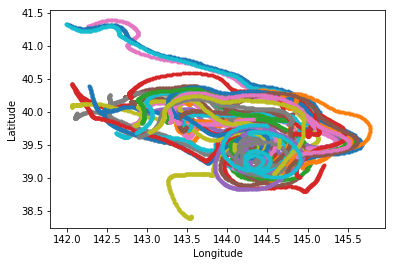

<module 'matplotlib.pyplot' from '/Users/dfan/anaconda3/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [15]:
plotTrajectoriesFile(output_name+'.nc',
                     tracerlon='lon',
                     tracerlat='lat')

In [20]:
plotTrajectoriesFile(output_name+'.nc', mode='movie2d_notebook', tracerfield='time')